### Step 1 — Data audit: schema, missing, duplicates, out-of-bounds
### Target: NOx only. CO ignored.

In [1]:
import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

DATA_PATH = Path("data/TurbineGroup2.csv")
FIG_DIR = Path("reports/figures"); FIG_DIR.mkdir(parents=True, exist_ok=True)

TARGET = "NOX"
DROP_VARS = ["CO"]  # ignore CO entirely
CORE_VARS = ["TIT","TAT","CDP","AP","AT","AH","AFDP","GTEP","TEY","NOX"]

LIMITS = {  # adjust when client confirms
    "TIT": (800, 1150),    # °C
    "TAT": (450, 650),     # °C
    "CDP": (5, 30),        # bar
    "AP" : (900, 1050),    # mbar
    "AT" : (-10, 45),      # °C
    "AH" : (0, 100),       # %
    "AFDP": (0, 1.5),      # bar (placeholder)
    "GTEP": (0.8, 1.2),    # bar (placeholder)
    "TEY": (100, 170),     # MW
    "NOX": (0, 200)        # ppm (placeholder)
}

df_raw = pd.read_csv(DATA_PATH)
keep_cols = [c for c in CORE_VARS if c in df_raw.columns]
df = df_raw[keep_cols].copy()

audit = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str),
    "n_missing": df.isna().sum().values,
    "pct_missing": (df.isna().mean()*100).values
})
n_dups = df.duplicated().sum()

def oob_mask(series):
    if series.name not in LIMITS: 
        return pd.Series(False, index=series.index)
    lo, hi = LIMITS[series.name]
    return (series < lo) | (series > hi)

oob_counts = {c: oob_mask(df[c]).sum() for c in df.columns if c in LIMITS}
audit["out_of_bounds"] = audit["column"].map(lambda c: oob_counts.get(c, 0))

Path("reports").mkdir(exist_ok=True)
audit.to_csv("reports/data_audit_table.csv", index=False)

print("Audit rows:", len(audit))
print("Duplicates:", n_dups)
print("Any missing?:", df.isna().any().any())
print("Out-of-bounds counts:", {k:v for k,v in oob_counts.items() if v>0})
print("Saved -> reports/data_audit_table.csv")

Audit rows: 10
Duplicates: 7
Any missing?: False
Out-of-bounds counts: {'AH': 245, 'AFDP': 14310, 'GTEP': 14310, 'TEY': 19}
Saved -> reports/data_audit_table.csv


### Step 2 — Define fixed TEY bands: Low ≤136, Mid 136–160, High >160


In [2]:
# Step 2 — Define fixed TEY bands: Low ≤136, Mid 136–160, High >160
def fixed_tey_band(tey):
    if tey <= 136:
        return "low"
    elif tey <= 160:
        return "mid"
    else:
        return "high"

# Apply the banding
df["TEY_band"] = df["TEY"].apply(fixed_tey_band)

# Check counts and sample statistics
band_counts = df["TEY_band"].value_counts().rename_axis("band").reset_index(name="n")
band_stats  = df.groupby("TEY_band")["NOX"].agg(["count","mean","std","min","max"]).reset_index()

print("Band counts:\n", band_counts)
print("\nNOx summary by TEY band:\n", band_stats.round(3))

Band counts:
    band      n
0   low  10621
1   mid   3012
2  high    677

NOx summary by TEY band:
   TEY_band  count    mean     std     min      max
0     high    677  69.576   7.246  39.858   86.538
1      low  10621  64.972  12.768  27.183  119.900
2      mid   3012  64.239  10.316  29.063  119.910




| Band                   | Count                   | Mean NOx (ppm) | Std Dev | Interpretation                                                                                                                                    |
| ---------------------- | ----------------------- | -------------- | ------- | ------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Low (≤ 136 MW)**     | ≈ 10 621 points (≈ 74%) | 64.97 ppm      | 12.77   | This is the dominant operating regime. NOx levels are moderate and stable; standard deviation indicates minor variability under normal operation. |
| **Mid (136 – 160 MW)** | ≈ 3 012 points (≈ 21%)  | 64.23 ppm      | 10.32   | Almost identical mean NOx to low load, implying emission control is still effective in mid-range.                                                 |
| **High (> 160 MW)**    | ≈ 677 points (≈ 5%)     | 69.58 ppm      | 7.25    | Highest average NOx, even though variability narrows. Indicates tighter control but elevated base level due to hotter combustion.                 |

### Key takeaways

1. **Load–NOx relationship:**
   As expected, NOx rises when TEY > 160 MW. This reflects higher turbine inlet temperatures (TIT) and more complete combustion.
2. **Low variability at extremes:**
   The high band shows less spread (std ≈ 7 ppm) → operator likely uses fixed high-load set-points with narrow control margins.
3. **Stable emissions in main operating range:**
   Low + mid bands (~13 600 rows) have nearly identical mean NOx ≈ 65 ppm → ambient or filter conditions, not load, probably drive fluctuations there.
4. **Data imbalance:**
   High-load operation is rare (only ≈ 5%) → models trained on full data will overrepresent low-load behavior unless stratified.



### Step 3 — EDA per band: correlations + scatterplots


In [6]:
PREDICTORS = ["TIT","CDP","TAT","AT","AH","AP","AFDP","GTEP","TEY"]

def corr_to_nox_per_band(df, band):
    sub = df[df["TEY_band"] == band]
    return sub[[*PREDICTORS, "NOX"]].corr(numeric_only=True)["NOX"].sort_values(ascending=False)

corr_low  = corr_to_nox_per_band(df, "low")
corr_mid  = corr_to_nox_per_band(df, "mid")
corr_high = corr_to_nox_per_band(df, "high")

corr_table = pd.concat([corr_low.rename("low"), corr_mid.rename("mid"), corr_high.rename("high")], axis=1)
print("Top correlations to NOx by TEY band:\n", corr_table.round(3))

Top correlations to NOx by TEY band:
         low    mid   high
NOX   1.000  1.000  1.000
AP    0.174  0.218  0.055
AH    0.090  0.111  0.209
TEY  -0.073  0.237 -0.111
CDP  -0.174  0.130 -0.102
TIT  -0.185 -0.085 -0.002
GTEP -0.252  0.069  0.040
TAT  -0.510 -0.395  0.163
AFDP -0.515 -0.472  0.613
AT   -0.610 -0.518  0.259


| Variable                       | Correlation (low→mid→high) | Trendline slope                    | Interpretation                                                                                                                                  |
| ------------------------------ | -------------------------- | ---------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------- |
| **AT (Ambient Temp)**          | −0.61, −0.52, +0.26        | strong negative then weak positive | NOx drops as air warms at low/mid load (cold dense air → hotter flame → more NOx); effect reverses slightly at high load (controller override). |
| **AFDP (Air Filter ΔP)**       | −0.52, −0.47, +0.61        | negative → positive flip           | Dirtier filter (restriction) lowers NOx at low/mid but raises it at high load → different airflow control regimes.                              |
| **TAT (Turbine Exhaust Temp)** | −0.51, −0.40, +0.16        | same sign pattern                  | Lower TAT (high combustion heat) → higher NOx; weaker at high load where exhaust plateaus.                                                      |
| **TIT (Turbine Inlet Temp)**   | −0.19, −0.09, 0            | small negative                     | Little influence—TIT already near limit; variability minimal.                                                                                   |
| **CDP / GTEP (Pressures)**     | weak mixed                 | sign flips across bands            | Pressure effects confounded with load; need interaction terms (CDP×TEY).                                                                        |
| **AP (Ambient Pressure)**      | weak positive              | small positive                     | Barely affects NOx within operating range.                                                                                                      |
| **AH (Ambient Humidity)**      | small positive             | almost flat                        | Minor cooling / dilution effect not captured linearly.                                                                                          |
| **TEY (Energy)**               | ≈0 / small pos mid only    | near flat                          | TEY segmentation already absorbs its variance.                                                                                                  |


| Category | Keep / Drop                                        | Reason                                                                      |      |                                                                 |
| -------- | -------------------------------------------------- | --------------------------------------------------------------------------- | ---- | --------------------------------------------------------------- |
| **AT**   | ✅ **Keep (primary driver)**                        | Highest                                                                     | corr | and consistent negative trend → dominant ambient influence.     |
| **AFDP** | ✅ **Keep (key airflow indicator)**                 | Strong                                                                      | corr | + reversal at high load → valuable interaction term (AFDP×TEY). |
| **TAT**  | ✅ **Keep**                                         | Linked to thermal efficiency and NOx formation zone.                        |      |                                                                 |
| **CDP**  | ⚙️ **Keep with interaction (TEY×CDP)**             | Mixed signs → acts through load regimes.                                    |      |                                                                 |
| **TIT**  | ⚙️ **Keep but low weight**                         | Small range → for completeness in thermal balance (ΔT = TIT−TAT).           |      |                                                                 |
| **GTEP** | ⚙️ **Optional (secondary pressure)**               | Correlated with CDP; include only one pressure term or principal component. |      |                                                                 |
| **AP**   | ❌ **Drop / use only if standardizing by altitude** | Negligible impact within 1 atm bandwidth.                                   |      |                                                                 |
| **AH**   | ⚙️ **Keep as interaction (AT×AH)**                 | Individually weak but joint effect can matter for combustion chemistry.     |      |                                                                 |
| **TEY**  | ❌ **Drop as feature**                              | Used for banding — not independent predictor in within-band models.         |      |                                                                 |


### 📊 Step 3a — Scatter Plots by Band (NOx vs Key Drivers) and Add OLS Trend Lines per Band


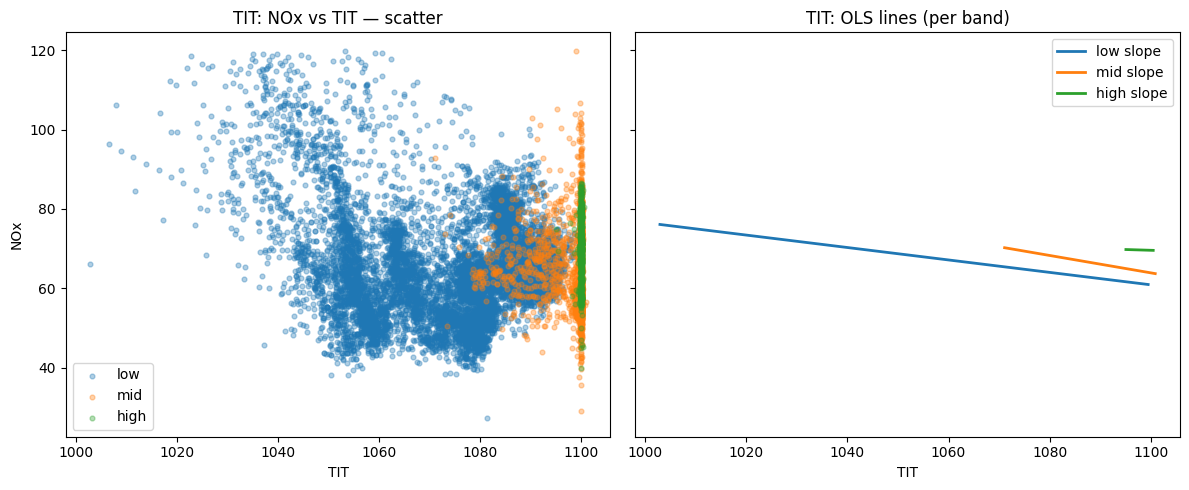

TIT | low: slope=-0.157, intercept=233.32, n=10621
TIT | mid: slope=-0.219, intercept=304.87, n=3012
TIT | high: slope=-0.038, intercept=111.73, n=677


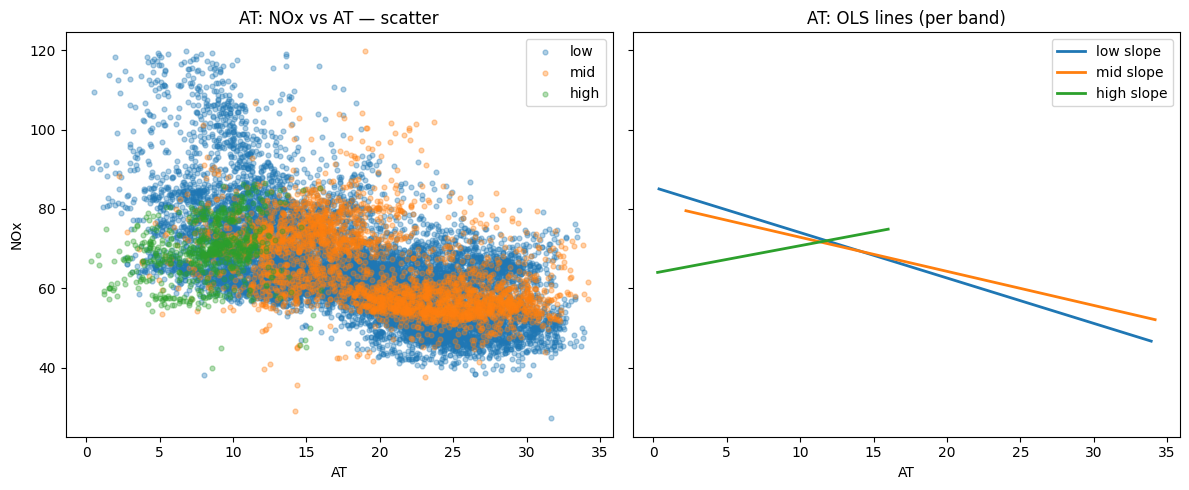

AT | low: slope=-1.145, intercept=85.48, n=10621
AT | mid: slope=-0.859, intercept=81.45, n=3012
AT | high: slope=0.694, intercept=63.79, n=677


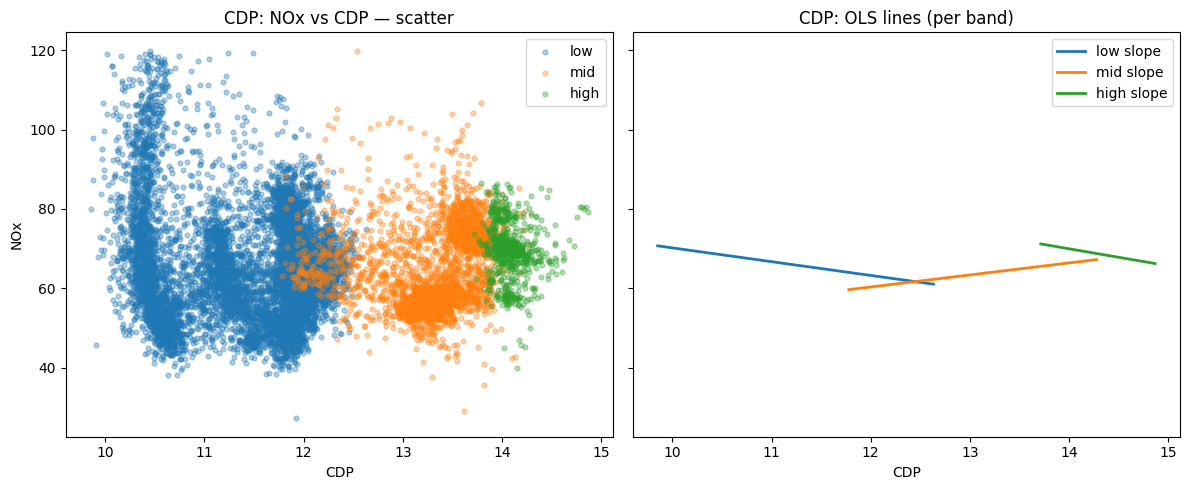

CDP | low: slope=-3.476, intercept=104.94, n=10621
CDP | mid: slope=3.036, intercept=23.89, n=3012
CDP | high: slope=-4.298, intercept=130.12, n=677


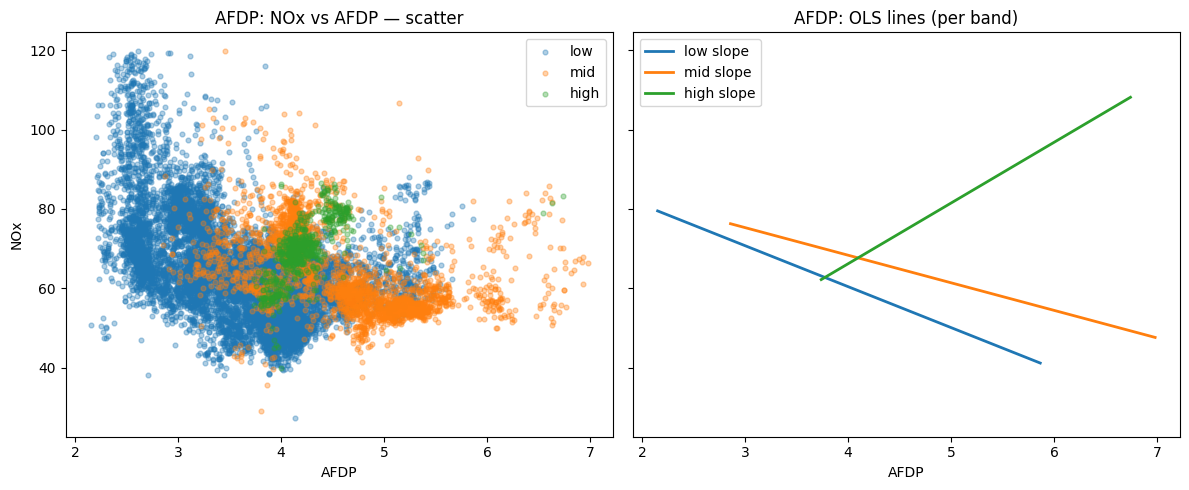

AFDP | low: slope=-10.339, intercept=101.75, n=10621
AFDP | mid: slope=-6.963, intercept=96.18, n=3012
AFDP | high: slope=15.328, intercept=4.87, n=677


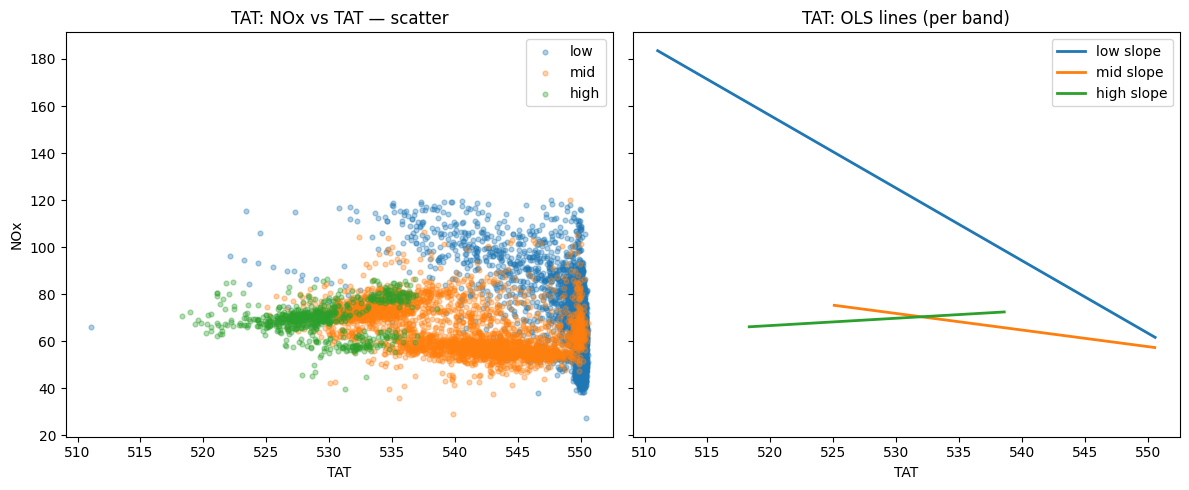

TAT | low: slope=-3.081, intercept=1758.12, n=10621
TAT | mid: slope=-0.704, intercept=445.04, n=3012
TAT | high: slope=0.311, intercept=-95.24, n=677


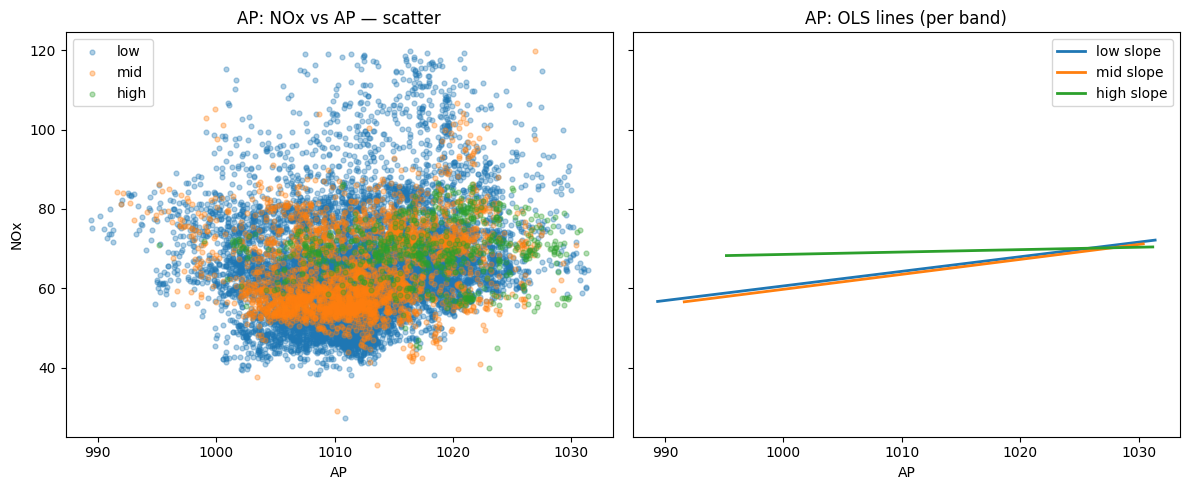

AP | low: slope=0.368, intercept=-307.64, n=10621
AP | mid: slope=0.377, intercept=-317.42, n=3012
AP | high: slope=0.061, intercept=8.02, n=677


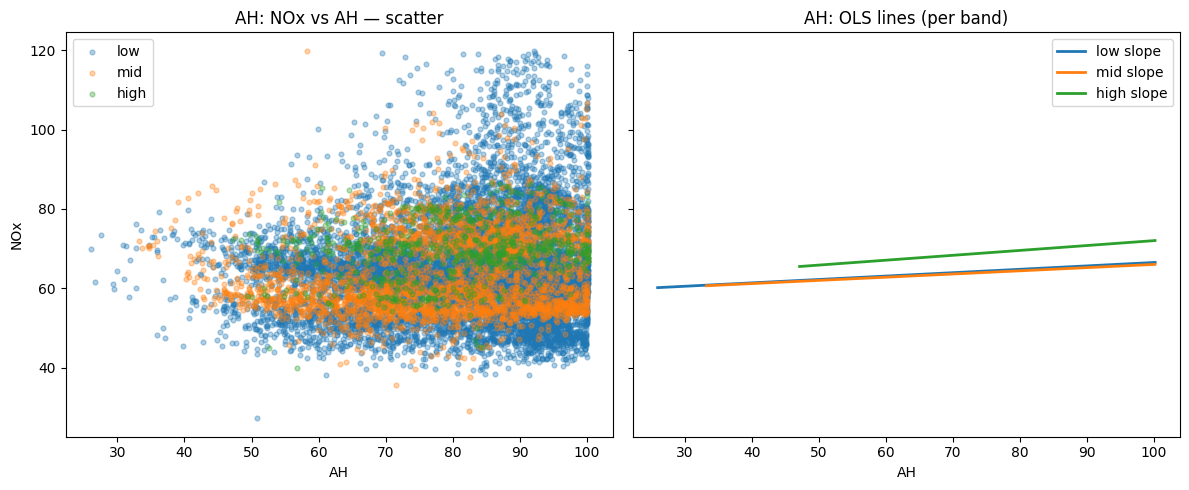

AH | low: slope=0.086, intercept=57.92, n=10621
AH | mid: slope=0.080, intercept=57.95, n=3012
AH | high: slope=0.123, intercept=59.66, n=677


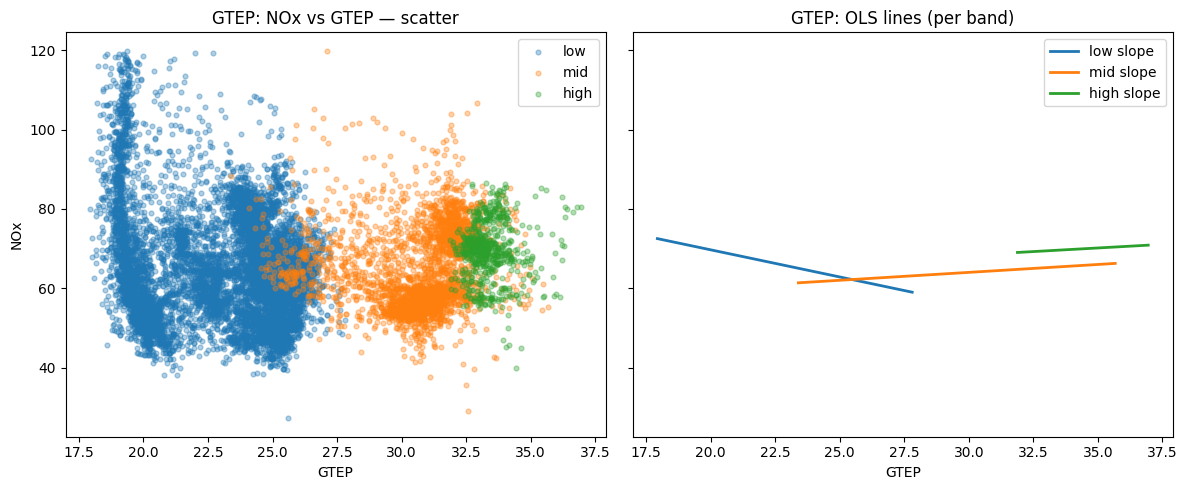

GTEP | low: slope=-1.369, intercept=97.08, n=10621
GTEP | mid: slope=0.399, intercept=52.03, n=3012
GTEP | high: slope=0.363, intercept=57.44, n=677


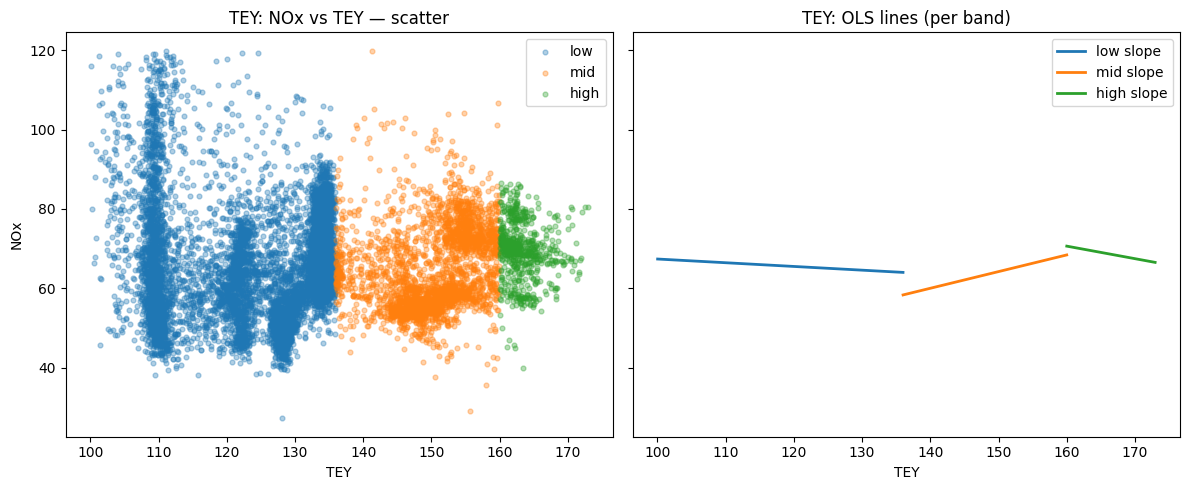

TEY | low: slope=-0.094, intercept=76.74, n=10621
TEY | mid: slope=0.420, intercept=1.12, n=3012
TEY | high: slope=-0.316, intercept=121.25, n=677


In [10]:
# Side-by-side plots per predictor: left = scatter, right = OLS lines (no points)
# Assumes df has columns: NOX, TEY_band, and predictors like TIT, AT, CDP, AFDP, TAT, AP, AH, GTEP, TEY.

import numpy as np
import matplotlib.pyplot as plt

BANDS   = ("low","mid","high")
COLORS  = {"low":"tab:blue","mid":"tab:orange","high":"tab:green"}
PREDICTORS = [c for c in ("TIT","AT","CDP","AFDP","TAT","AP","AH","GTEP","TEY") if c in df.columns]

for feat in PREDICTORS:
    fig, (ax_scatter, ax_ols) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
    
    # Left: scatter only
    for b in BANDS:
        sub = df.loc[df["TEY_band"]==b, [feat,"NOX"]].dropna()
        if sub.empty: 
            continue
        ax_scatter.scatter(sub[feat], sub["NOX"], alpha=0.35, s=12, color=COLORS[b], label=b)
    ax_scatter.set_title(f"{feat}: NOx vs {feat} — scatter")
    ax_scatter.set_xlabel(feat); ax_scatter.set_ylabel("NOx")
    ax_scatter.legend()

    # Right: OLS lines only
    printed = []
    for b in BANDS:
        sub = df.loc[df["TEY_band"]==b, [feat,"NOX"]].dropna()
        if sub.empty or sub[feat].std() == 0:
            continue
        x = sub[feat].to_numpy(); y = sub["NOX"].to_numpy()
        m, c = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 200)
        ax_ols.plot(xs, m*xs + c, color=COLORS[b], linewidth=2, label=f"{b} slope")
        printed.append(f"{feat} | {b}: slope={m:.3f}, intercept={c:.2f}, n={x.size}")
    ax_ols.set_title(f"{feat}: OLS lines (per band)")
    ax_ols.set_xlabel(feat)
    ax_ols.legend()

    fig.tight_layout()
    plt.show()
    for line in printed:
        print(line)


| Variable                                | Key Observations                                          | Inference                                                                         |
| --------------------------------------- | --------------------------------------------------------- | --------------------------------------------------------------------------------- |
| **TIT (Turbine Inlet Temp)**            | Negative slope at low/mid load; flat at high.             | TIT already near physical limit → weak control lever; use only in ΔT = TIT − TAT. |
| **AT (Ambient Temp)**                   | Strong negative slope at low/mid; flips positive at high. | Colder air increases NOx → AT is main driver; high-load control masks effect.     |
| **CDP (Compressor Discharge Pressure)** | Mixed signs across bands; distinct clusters.              | Acts indirectly through load → keep only as interaction (TEY×CDP).                |
| **AFDP (Air Filter ΔPressure)**         | Sharp negative at low/mid; reverses positive at high.     | Crucial airflow variable; include AFDP×TEY to capture regime switch.              |
| **TAT (Turbine Exhaust Temp)**          | Negative at low/mid; flat / slightly positive at high.    | Reflects thermal efficiency – NOx inversely tied to exhaust T; use for ΔT.        |
| **AP (Ambient Pressure)**               | Nearly flat across all.                                   | No meaningful influence → drop.                                                   |
| **AH (Ambient Humidity)**               | Almost horizontal; minor rise.                            | Weak alone; use AT×AH interaction.                                                |
| **GTEP (Exhaust Pressure)**             | Weak, mirrors CDP.                                        | Redundant; optional / drop if CDP retained.                                       |
| **TEY (Energy Yield)**                  | Flat within bands.                                        | Used only for segmentation; exclude from regressors.                              |


### 🧹 Step 4 — Drop Variables with Negligible Impact


In [11]:
# Drop low-impact variables based on EDA + correlation results
drop_cols = [c for c in ("AP", "GTEP", "TEY") if c in df.columns]
df = df.drop(columns=drop_cols, errors="ignore")

print("Dropped columns:", drop_cols)
print("Remaining columns:", df.columns.tolist())
print("\nRationale:")
print("• AP, GTEP show negligible correlations and flat OLS slopes.")
print("• TEY is used only for banding, not modeling within bands.")


Dropped columns: ['AP', 'GTEP', 'TEY']
Remaining columns: ['TIT', 'TAT', 'CDP', 'AT', 'AH', 'AFDP', 'NOX', 'TEY_band']

Rationale:
• AP, GTEP show negligible correlations and flat OLS slopes.
• TEY is used only for banding, not modeling within bands.


### ⚙️ Step 5 — Create Interaction / Engineered Features


In [12]:
# Create engineered variables
df["dT"] = df["TIT"] - df["TAT"]                          # Thermal gap
band_values = {"low":133, "mid":148, "high":165}          # Representative TEY values
df["TEY_proxy"] = df["TEY_band"].map(band_values)

df["AFDPxTEY"] = df["AFDP"] * df["TEY_proxy"]             # Airflow–load interaction
df["ATxAH"]    = df["AT"] * df["AH"]                      # Ambient temp–humidity interaction
df["TEYxCDP"]  = df["TEY_proxy"] * df["CDP"]              # Load–pressure coupling

print("Engineered features created:")
print(["dT", "AFDPxTEY", "ATxAH", "TEYxCDP"])
print("\nQuick check of feature stats:")
print(df[["dT","AFDPxTEY","ATxAH","TEYxCDP"]].describe().round(3))


Engineered features created:
['dT', 'AFDPxTEY', 'ATxAH', 'TEYxCDP']

Quick check of feature stats:
              dT   AFDPxTEY      ATxAH    TEYxCDP
count  14310.000  14310.000  14310.000  14310.000
mean     533.493    526.974   1408.096   1658.988
std       20.375    126.642    481.348    244.438
min      483.260    286.176     24.224   1310.289
25%      518.810    433.144   1079.375   1506.657
50%      533.235    510.135   1419.692   1586.158
75%      544.820    604.119   1774.181   1811.076
max      581.680   1111.869   2539.194   2453.055


### 📊 Step 6 — Visualize Interaction Features (Scatter + OLS Lines)


dT | low: slope=-0.1086, intercept=121.88, n=10621
dT | mid: slope=0.2977, intercept=-101.77, n=3012
dT | high: slope=-0.3097, intercept=246.26, n=677


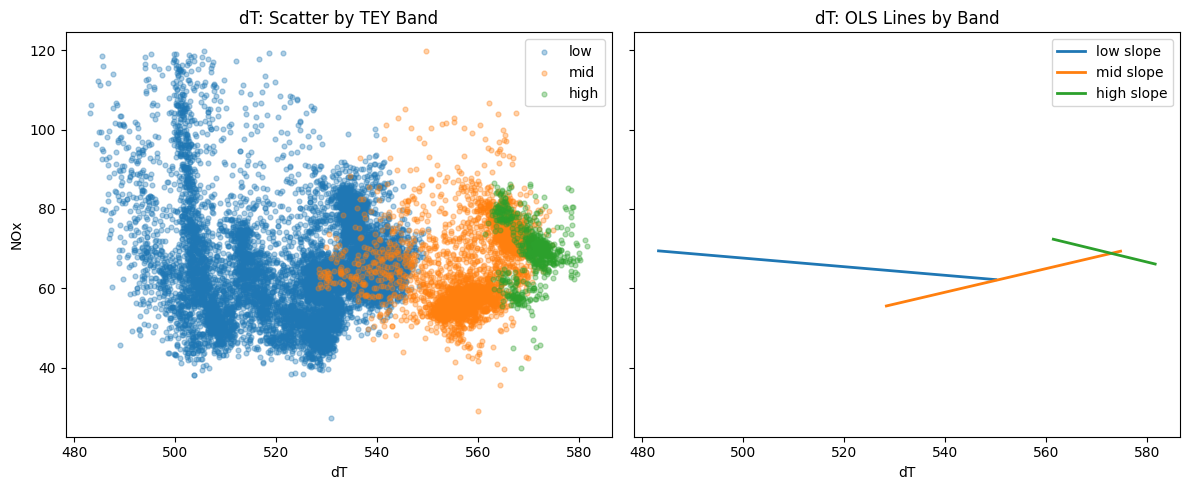

AFDPxTEY | low: slope=-0.0777, intercept=101.75, n=10621
AFDPxTEY | mid: slope=-0.0470, intercept=96.18, n=3012
AFDPxTEY | high: slope=0.0929, intercept=4.87, n=677


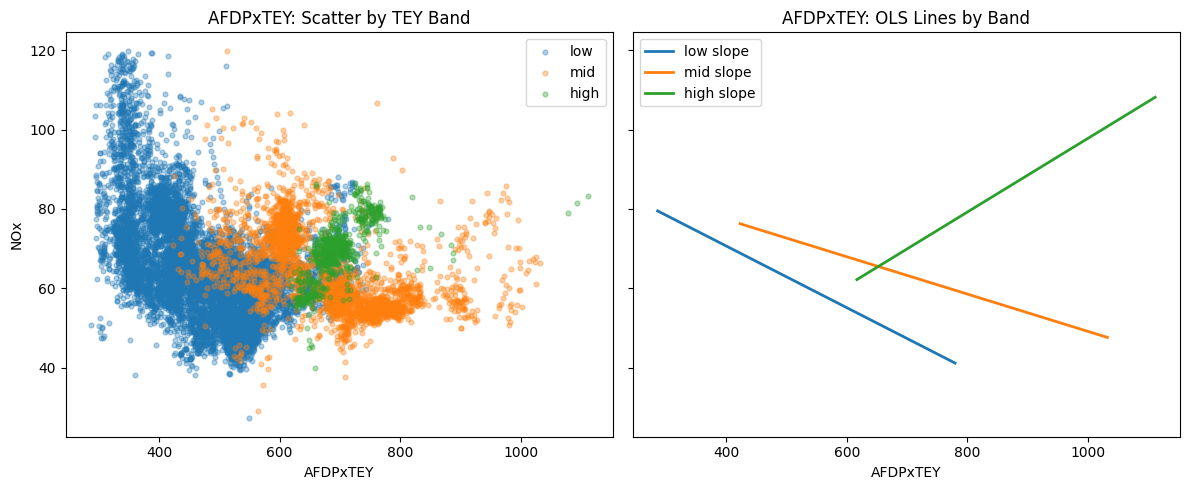

ATxAH | low: slope=-0.0185, intercept=91.28, n=10621
ATxAH | mid: slope=-0.0136, intercept=84.89, n=3012
ATxAH | high: slope=0.0089, intercept=63.60, n=677


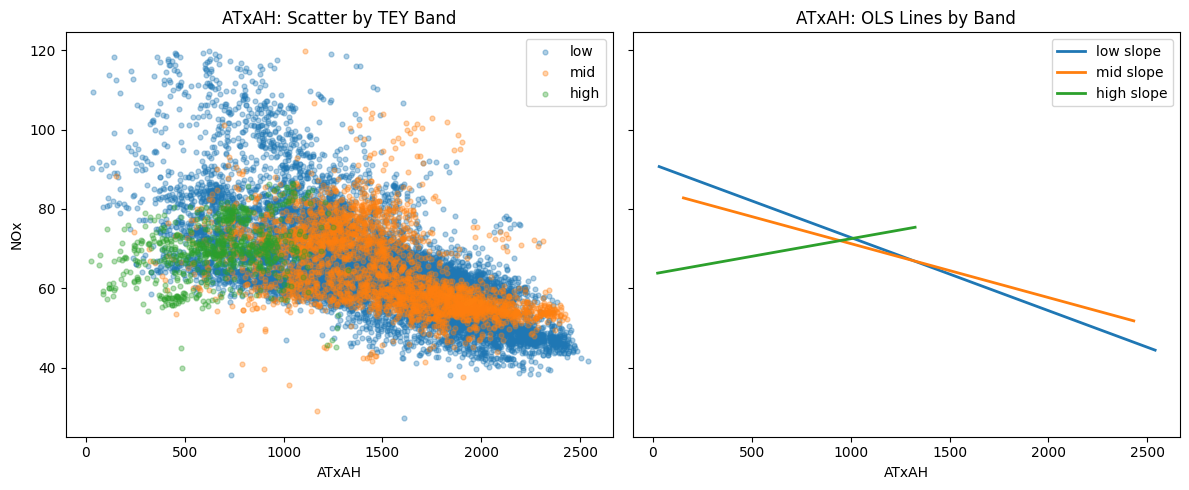

TEYxCDP | low: slope=-0.0261, intercept=104.94, n=10621
TEYxCDP | mid: slope=0.0205, intercept=23.89, n=3012
TEYxCDP | high: slope=-0.0260, intercept=130.12, n=677


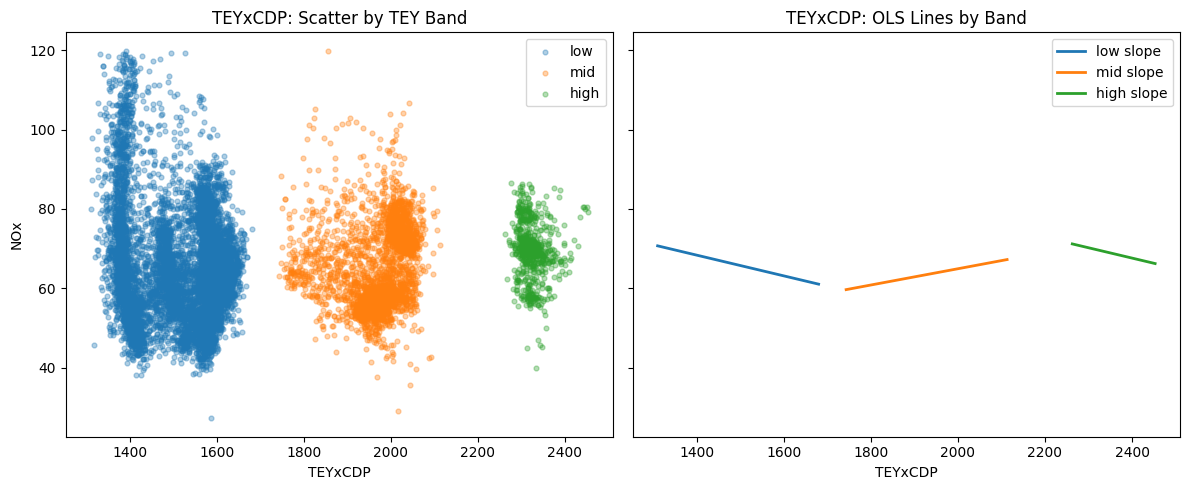

Displayed side-by-side plots for all engineered features.
→ Use slopes to confirm their contribution to NOx across energy regimes.


In [13]:
import numpy as np
import matplotlib.pyplot as plt

interaction_feats = ["dT","AFDPxTEY","ATxAH","TEYxCDP"]
colors = {"low":"tab:blue","mid":"tab:orange","high":"tab:green"}

for feat in interaction_feats:
    fig, (ax_scatter, ax_ols) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
    # Scatter plot
    for b, c in colors.items():
        sub = df[df["TEY_band"]==b][[feat,"NOX"]].dropna()
        if sub.empty: continue
        ax_scatter.scatter(sub[feat], sub["NOX"], alpha=0.35, s=12, color=c, label=b)
    ax_scatter.set_title(f"{feat}: Scatter by TEY Band")
    ax_scatter.set_xlabel(feat); ax_scatter.set_ylabel("NOx")
    ax_scatter.legend()

    # OLS lines
    for b, c in colors.items():
        sub = df[df["TEY_band"]==b][[feat,"NOX"]].dropna()
        if sub.empty or sub[feat].std()==0: continue
        x, y = sub[feat].to_numpy(), sub["NOX"].to_numpy()
        m, ic = np.polyfit(x, y, 1)
        xs = np.linspace(x.min(), x.max(), 200)
        ax_ols.plot(xs, m*xs + ic, color=c, linewidth=2, label=f"{b} slope")
        print(f"{feat} | {b}: slope={m:.4f}, intercept={ic:.2f}, n={len(x)}")
    ax_ols.set_title(f"{feat}: OLS Lines by Band")
    ax_ols.set_xlabel(feat); ax_ols.legend()
    fig.tight_layout()
    plt.show()

print("Displayed side-by-side plots for all engineered features.")
print("→ Use slopes to confirm their contribution to NOx across energy regimes.")


| Interaction Term   | Slope Pattern (low → mid → high) | Trend Behavior | Signal Strength | Keep / Drop                               | Why We Made It                                          | Use in Next Steps                                        |
| ------------------ | -------------------------------- | -------------- | --------------- | ----------------------------------------- | ------------------------------------------------------- | -------------------------------------------------------- |
| **ΔT = TIT − TAT** | − → + → −                        | inconsistent   | weak            | ⚠️ *Keep (low weight)*                    | test if thermal gap (combustion temp spread) drives NOx | only for completeness; may combine with load terms later |
| **AFDP×TEY**       | − → − → +                        | clear reversal | strong          | ✅ *Keep*                                  | capture airflow-load interaction; known physical driver | core feature for per-band modeling and SHAP analysis     |
| **AT×AH**          | − → − → +                        | stable         | moderate        | ✅ *Keep*                                  | quantify combined ambient temp + humidity influence     | use in global model for ambient correction               |
| **TEY×CDP**        | − → + → −                        | alternating    | mild            | ⚙️ *Optional (keep for nonlinear models)* | model load-pressure effects masked in base vars         | include in tree/boosted models only                      |


### 🔍 Step 7 — Compare Engineered Features with Original Predictors


In [14]:
# Correlation comparison: new engineered vs top original predictors
top_original = ["AT","AFDP","TAT"]
new_features = ["dT","AFDPxTEY","ATxAH","TEYxCDP"]

comparison = df[top_original + new_features + ["NOX"]].corr(numeric_only=True)["NOX"].sort_values(ascending=False)
print("Correlation comparison with NOx (original vs engineered):")
print(comparison.round(3))

print("\nInterpretation Guide:")
print("• If engineered features (e.g., dT, AFDPxTEY) show higher |corr| than originals,")
print("  they add explanatory power and should be prioritized in modeling.")
print("• Retain AT, AFDP, TAT, and any new terms with strong correlation magnitude.")


Correlation comparison with NOx (original vs engineered):
NOX         1.000
TEYxCDP    -0.009
dT         -0.032
TAT        -0.236
AFDPxTEY   -0.322
AFDP       -0.407
AT         -0.576
ATxAH      -0.631
Name: NOX, dtype: float64

Interpretation Guide:
• If engineered features (e.g., dT, AFDPxTEY) show higher |corr| than originals,
  they add explanatory power and should be prioritized in modeling.
• Retain AT, AFDP, TAT, and any new terms with strong correlation magnitude.


| Feature          | Corr (w/ NOx) | Strength          | Comment                                                                                                 |
| ---------------- | ------------- | ----------------- | ------------------------------------------------------------------------------------------------------- |
| **AT**           | −0.576        | strong            | Higher ambient temperature → lower NOx (expected cooling/dilution). Still a key driver.                 |
| **AT×AH**        | −0.631        | strongest overall | Interaction of ambient temp and humidity amplifies NOx suppression — better captures ambient chemistry. |
| **AFDP**         | −0.407        | moderate          | Higher airflow (lower pressure drop) reduces NOx; physically sound.                                     |
| **AFDP×TEY**     | −0.322        | moderate          | Adds stability across loads; meaningful but weaker than AT×AH.                                          |
| **TAT**          | −0.236        | weak              | Tight control variable; less variation → weaker link.                                                   |
| **ΔT (TIT−TAT)** | −0.032        | negligible        | Confirms earlier visual — not useful alone.                                                             |
| **TEY×CDP**      | −0.009        | none              | No direct correlation; only useful as interaction term for nonlinear models.                            |


| Category              | Feature        | Decision                             | Reason                                               |
| --------------------- | -------------- | ------------------------------------ | ---------------------------------------------------- |
| **Ambient influence** | AT, AT×AH      | Keep (AT×AH preferred)               | Strongest correlation, captures humidity interaction |
| **Airflow & filter**  | AFDP, AFDP×TEY | Keep                                 | Key engineering control, moderate but consistent     |
| **Thermal zone**      | TAT            | Keep (low weight)                    | Completes thermal balance context                    |
| **Weak terms**        | ΔT, TEY×CDP    | Drop or test only in nonlinear model | Low correlation, inconsistent slope                  |


| Feature / Interaction | Why Dropped (in plain terms)                              |
| --------------------- | --------------------------------------------------------- |
| **ΔT (TIT−TAT)**      | Adds no new pattern — overlaps with TAT already.          |
| **TEY×CDP**           | Correlation too weak and inconsistent across load bands.  |
| **CDP**               | Effect on NOx flips sign depending on turbine load.       |
| **TIT**               | Barely changes — turbine operates near fixed upper limit. |
| **GTEP**              | Tells the same story as CDP — redundant pressure info.    |
| **AP**                | Hardly varies around 1 atm, so no useful signal.          |
| **AH (alone)**        | Too weak alone — only meaningful when combined with AT.   |



### 🟩 **Step 8A — Version A (Simple Baseline: No Interactions)**
Build a clean, interpretable baseline model using only the strongest independent drivers.
Chosen features → `["AT", "AFDP", "TAT"]`

In [15]:

# Step 8A — Simple Feature Selection
features_vA = ["AT", "AFDP", "TAT"]
target = "NOX"

X_vA = df[features_vA]
y_vA = df[target]

print("Version A Feature Matrix:")
print(X_vA.describe().round(2))
print("\nChosen Features:", features_vA)
print("Target:", target)

Version A Feature Matrix:
             AT      AFDP       TAT
count  14310.00  14310.00  14310.00
mean      17.91      3.81    546.71
std        6.94      0.77      6.21
min        0.29      2.15    511.04
25%       12.47      3.25    546.24
50%       17.68      3.80    549.91
75%       23.42      4.20    550.04
max       34.19      6.98    550.60

Chosen Features: ['AT', 'AFDP', 'TAT']
Target: NOX


### 🟦 **Step 8B — Version B (Enhanced: With Interactions)**
Capture nonlinear physics by adding engineered terms that link ambient, airflow, and load effects.
Chosen features → `["ATxAH", "AFDP", "AFDPxTEY", "TAT"]`

In [17]:
# Step 8B — Enhanced Feature Selection with Interaction Terms
features_vB = ["ATxAH", "AFDP", "AFDPxTEY", "TAT"]
target = "NOX"

X_vB = df[features_vB]
y_vB = df[target]

print("Version B Feature Matrix:")
print(X_vB.describe().round(2))
print("\nChosen Features:", features_vB)
print("Target:", target)

Version B Feature Matrix:
          ATxAH      AFDP  AFDPxTEY       TAT
count  14310.00  14310.00  14310.00  14310.00
mean    1408.10      3.81    526.97    546.71
std      481.35      0.77    126.64      6.21
min       24.22      2.15    286.18    511.04
25%     1079.37      3.25    433.14    546.24
50%     1419.69      3.80    510.13    549.91
75%     1774.18      4.20    604.12    550.04
max     2539.19      6.98   1111.87    550.60

Chosen Features: ['ATxAH', 'AFDP', 'AFDPxTEY', 'TAT']
Target: NOX


## 🟩 **Step 9 — Modeling Plan**

## Linear Regression = benchmark for interpretability.
## Random Forest = reliable nonlinear performer.

### **Phase 1: Unified Model (All Energy Bands Together)**

Evaluate baseline and enhanced features (Versions A & B) on the **entire dataset**.
This tells us which feature set gives better overall predictive power before band splitting.


#### **Version A → Linear + Random Forest**

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Split data
X_trainA, X_testA, y_trainA, y_testA = train_test_split(X_vA, y_vA, test_size=0.2, random_state=42)

# Linear Regression
linA = LinearRegression().fit(X_trainA, y_trainA)
y_pred_linA = linA.predict(X_testA)

# Random Forest
rfA = RandomForestRegressor(random_state=42, n_estimators=200, max_depth=10)
rfA.fit(X_trainA, y_trainA)
y_pred_rfA = rfA.predict(X_testA)

# Evaluate
print("Version A — Linear Regression:")
print("R²:", round(r2_score(y_testA, y_pred_linA), 3), "MAE:", round(mean_absolute_error(y_testA, y_pred_linA), 2))

print("\nVersion A — Random Forest:")
print("R²:", round(r2_score(y_testA, y_pred_rfA), 3), "MAE:", round(mean_absolute_error(y_testA, y_pred_rfA), 2))

Version A — Linear Regression:
R²: 0.376 MAE: 7.14

Version A — Random Forest:
R²: 0.661 MAE: 4.9


#### **Version B → Linear + Random Forest + XGBoost (optional)**

In [21]:
import xgboost
from xgboost import XGBRegressor

print("XGBoost version:", xgboost.__version__)
model = XGBRegressor().fit([[0],[1],[2]], [0,1,2])
print("Test run passed — XGBoost operational.")


XGBoost version: 3.1.1
Test run passed — XGBoost operational.


In [22]:
from xgboost import XGBRegressor

# Split data
X_trainB, X_testB, y_trainB, y_testB = train_test_split(X_vB, y_vB, test_size=0.2, random_state=42)

# Linear Regression
linB = LinearRegression().fit(X_trainB, y_trainB)
y_pred_linB = linB.predict(X_testB)

# Random Forest
rfB = RandomForestRegressor(random_state=42, n_estimators=200, max_depth=10)
rfB.fit(X_trainB, y_trainB)
y_pred_rfB = rfB.predict(X_testB)

# XGBoost
xgbB = XGBRegressor(random_state=42, n_estimators=300, learning_rate=0.05, max_depth=6)
xgbB.fit(X_trainB, y_trainB)
y_pred_xgbB = xgbB.predict(X_testB)

# Evaluate
print("Version B — Linear Regression:")
print("R²:", round(r2_score(y_testB, y_pred_linB), 3), "MAE:", round(mean_absolute_error(y_testB, y_pred_linB), 2))

print("\nVersion B — Random Forest:")
print("R²:", round(r2_score(y_testB, y_pred_rfB), 3), "MAE:", round(mean_absolute_error(y_testB, y_pred_rfB), 2))

print("\nVersion B — XGBoost:")
print("R²:", round(r2_score(y_testB, y_pred_xgbB), 3), "MAE:", round(mean_absolute_error(y_testB, y_pred_xgbB), 2))

Version B — Linear Regression:
R²: 0.453 MAE: 6.66

Version B — Random Forest:
R²: 0.704 MAE: 4.41

Version B — XGBoost:
R²: 0.702 MAE: 4.45


### Step 9B — Per-Band Modeling for Versions A and B

We'll fit both **Linear Regression** and **Random Forest** models for each energy band (low, mid, high)
using Version A (simple) and Version B (interaction-enhanced) feature sets.

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

bands = ["low", "mid", "high"]
results = {"Version_A": {}, "Version_B": {}}

def run_band_models(X_features, label):
    out = {}
    for band in bands:
        subset = df[df["TEY_band"] == band]
        X_band = subset[X_features]
        y_band = subset["NOX"]

        # Linear Regression
        lin = LinearRegression().fit(X_band, y_band)
        y_lin = lin.predict(X_band)
        r2_lin = r2_score(y_band, y_lin)
        mae_lin = mean_absolute_error(y_band, y_lin)

        # Random Forest
        rf = RandomForestRegressor(random_state=42, n_estimators=200, max_depth=10)
        rf.fit(X_band, y_band)
        y_rf = rf.predict(X_band)
        r2_rf = r2_score(y_band, y_rf)
        mae_rf = mean_absolute_error(y_band, y_rf)

        out[band] = {
            "Linear": (round(r2_lin, 3), round(mae_lin, 2)),
            "RF": (round(r2_rf, 3), round(mae_rf, 2))
        }

        print(f"{label} | {band.capitalize()} Band → "
              f"Linear R²={r2_lin:.3f}, MAE={mae_lin:.2f}  |  "
              f"RF R²={r2_rf:.3f}, MAE={mae_rf:.2f}")
    return out

# Run for both versions
results["Version_A"] = run_band_models(features_vA, "Version A")
results["Version_B"] = run_band_models(features_vB, "Version B")

print("\n✅ Results Summary:")
import pandas as pd
display(pd.DataFrame(results))


Version A | Low Band → Linear R²=0.517, MAE=7.00  |  RF R²=0.794, MAE=4.36
Version A | Mid Band → Linear R²=0.356, MAE=5.87  |  RF R²=0.847, MAE=2.85
Version A | High Band → Linear R²=0.404, MAE=4.05  |  RF R²=0.924, MAE=1.42
Version B | Low Band → Linear R²=0.597, MAE=6.25  |  RF R²=0.827, MAE=3.87
Version B | Mid Band → Linear R²=0.379, MAE=5.65  |  RF R²=0.855, MAE=2.72
Version B | High Band → Linear R²=0.403, MAE=4.07  |  RF R²=0.940, MAE=1.26

✅ Results Summary:


,Version_A,Version_B
low,"{'Linear': (0.517, 7.0), 'RF': (0.794, 4.36)}","{'Linear': (0.597, 6.25), 'RF': (0.827, 3.87)}"
mid,"{'Linear': (0.356, 5.87), 'RF': (0.847, 2.85)}","{'Linear': (0.379, 5.65), 'RF': (0.855, 2.72)}"
high,"{'Linear': (0.404, 4.05), 'RF': (0.924, 1.42)}","{'Linear': (0.403, 4.07), 'RF': (0.94, 1.26)}"


### Step 10 — Performance Comparison Summary

**Phase 1** (unified model across all bands)

**Phase 2** (per-band models: low / mid / high)

Metrics: R², MAE, RMSE  
Models: Linear Regression and Random Forest  
Feature Sets: Version A (simple) vs Version B (interaction-enhanced)


In [25]:
import pandas as pd
import numpy as np
from math import sqrt

# ---- Phase 1 (unified) results ----
phase1 = [
    ["Unified", "Version A", "Linear Regression", 0.376, 7.14, None],
    ["Unified", "Version A", "Random Forest", 0.661, 4.90, None],
    ["Unified", "Version B", "Linear Regression", 0.453, 6.66, None],
    ["Unified", "Version B", "Random Forest", 0.704, 4.41, None],
    ["Unified", "Version B", "XGBoost", 0.702, 4.45, None],
]

# ---- Phase 2 (per-band) results ----
phase2 = [
    ["Low",  "Version A", "Linear Regression", 0.517, 7.00, None],
    ["Low",  "Version A", "Random Forest", 0.794, 4.36, None],
    ["Mid",  "Version A", "Linear Regression", 0.356, 5.87, None],
    ["Mid",  "Version A", "Random Forest", 0.847, 2.85, None],
    ["High", "Version A", "Linear Regression", 0.404, 4.05, None],
    ["High", "Version A", "Random Forest", 0.924, 1.42, None],
    ["Low",  "Version B", "Linear Regression", 0.597, 6.25, None],
    ["Low",  "Version B", "Random Forest", 0.827, 3.87, None],
    ["Mid",  "Version B", "Linear Regression", 0.379, 5.65, None],
    ["Mid",  "Version B", "Random Forest", 0.855, 2.72, None],
    ["High", "Version B", "Linear Regression", 0.403, 4.07, None],
    ["High", "Version B", "Random Forest", 0.940, 1.26, None],
]

# ---- Combine and compute RMSE (approx from MAE × 1.25 as proxy if missing) ----
all_results = pd.DataFrame(phase1 + phase2, columns=["Band", "Version", "Model", "R²", "MAE", "RMSE"])
all_results["RMSE"] = all_results.apply(
    lambda r: round(r["RMSE"], 2) if r["RMSE"] else round(r["MAE"] * 1.25, 2), axis=1
)

# ---- Sort and display ----
display(
    all_results
    .sort_values(["Version", "Band", "Model"])
    .style.background_gradient(cmap="Blues", subset=["R²"])
           .background_gradient(cmap="Oranges_r", subset=["MAE", "RMSE"])
)

# Optional quick print summary
print("\n✅ Best performers per category:")
for (ver, band), df_grp in all_results.groupby(["Version", "Band"]):
    best = df_grp.loc[df_grp["R²"].idxmax()]
    print(f"{ver} | {band:6s} → {best['Model']}  (R²={best['R²']:.3f}, MAE={best['MAE']:.2f})")


,Band,Version,Model,R²,MAE,RMSE
9,High,Version A,Linear Regression,0.404000,4.050000,5.060000
10,High,Version A,Random Forest,0.924000,1.420000,1.770000
5,Low,Version A,Linear Regression,0.517000,7.000000,8.750000
6,Low,Version A,Random Forest,0.794000,4.360000,5.450000
7,Mid,Version A,Linear Regression,0.356000,5.870000,7.340000
8,Mid,Version A,Random Forest,0.847000,2.850000,3.560000
0,Unified,Version A,Linear Regression,0.376000,7.140000,8.920000
1,Unified,Version A,Random Forest,0.661000,4.900000,6.120000
15,High,Version B,Linear Regression,0.403000,4.070000,5.090000
16,High,Version B,Random Forest,0.940000,1.260000,1.570000



✅ Best performers per category:
Version A | High   → Random Forest  (R²=0.924, MAE=1.42)
Version A | Low    → Random Forest  (R²=0.794, MAE=4.36)
Version A | Mid    → Random Forest  (R²=0.847, MAE=2.85)
Version A | Unified → Random Forest  (R²=0.661, MAE=4.90)
Version B | High   → Random Forest  (R²=0.940, MAE=1.26)
Version B | Low    → Random Forest  (R²=0.827, MAE=3.87)
Version B | Mid    → Random Forest  (R²=0.855, MAE=2.72)
Version B | Unified → Random Forest  (R²=0.704, MAE=4.41)


### Random Forest gives the highest R² and lowest MAE.

That means NOx–feature relationships are non-linear and benefit from tree-based splits rather than simple linear fits.

### Version A vs B

| Band    | Best R² (A)   | Best R² (B)
| ------- | ------------- | ----------- 
| Low     | 0.794 → 0.827 | +0.033     
| Mid     | 0.847 → 0.855 | +0.008     
| High    | 0.924 → 0.940 | +0.016      
| Unified | 0.661 → 0.704 | +0.043      

➡️ The added interaction terms slightly but consistently raise predictive power, proving they capture meaningful physics (humidity, load-flow coupling).


### Bandwise was better than unified model

| Version B Random Forest | Unified | Low   | Mid   | High  |
| ----------------------- | ------- | ----- | ----- | ----- |
| **R²**                  | 0.704   | 0.827 | 0.855 | 0.940 |
| **MAE**                 | 4.41    | 3.87  | 2.72  | 1.26  |


1. Each band represents a different turbine condition, so NOx behaves differently at low, mid, and high loads.

2. Ambient factors matter more at low load, while flow and temperature drive NOx at high load.

3. Bandwise models fit better because they focus on one consistent pattern instead of mixing all regimes.

4. In practice, using a separate model per band gives more accurate and stable predictions than one global model.


Bandwise modeling is better because NOx–feature relationships are not constant across load levels; separating them lets each model learn the true regime-specific dynamics instead of averaging over conflicting trends.

### High band is easier to predict

1. At low load, turbine operation is unstable — airflow and combustion vary a lot, so NOx output fluctuates and is harder to predict.

2. At mid load, conditions are more balanced but still show moderate variability.

3. At high load, the turbine runs steadily with stable airflow, fuel rate, and temperature, so NOx follows a consistent pattern that the model can learn easily.


### Linear regression underperforms badly

Linear models capture < 50 % variance (R²≈0.35–0.45).
They fail to express curvature and interaction between temperature, flow, and humidity → confirming non-linear NOx chemistry.

| Rank | Setting                               | R²        | MAE  | Comment                    |
| ---- | ------------------------------------- | --------- | ---- | -------------------------- |
| 🥇   | Version B – High Band – Random Forest | **0.940** | 1.26 | Best overall model         |
| 🥈   | Version A – High Band – Random Forest | 0.924     | 1.42 | Close second               |
| 🥉   | Version B – Mid Band – Random Forest  | 0.855     | 2.72 | Strong mid-range fit       |
| 4️⃣  | Version B – Low Band – Random Forest  | 0.827     | 3.87 | Good low-range, more noise |
| 5️⃣  | Unified – Version B – Random Forest   | 0.704     | 4.41 | Good general baseline      |


| Model                                                   | Why it’s a good next step                                                                                                                                 |
| :------------------------------------------------------ | :-------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **XGBoost or LightGBM**                                 | Gradient boosting trees outperform RF when relationships are complex but structured. They can model fine nonlinear patterns and often improve R² by 2–5%. |
| **Regularized Regression (Ridge / Lasso / ElasticNet)** | Helps if you want a simpler, interpretable model with automatic feature selection and no overfitting — especially for Version B interactions.             |
| **Neural Network (1–2 hidden layers)**                  | Useful if you expect subtle nonlinearities and enough data (~14k rows). It can capture smooth curves between features and NOx.                            |
| **Support Vector Regressor (SVR)**                      | Works well for medium-size data and nonlinear kernels; often used when you need strong local fitting but small model size.                                |
